In [ ]:
# PER/PBR, ROE 전략 
# 0. 데이터 가져오기
# 1. PER/PBR, ROE 순위 산출하기 
# 2. 수익률 산출하기 

In [79]:
# 0.S&P데이터 가져오기 

import FinanceDataReader as fdr
import os
import json
import pandas as pd
import numpy as np
pd.set_option('display.float_format', lambda x: '%.2f' % x)

sp500 = fdr.StockListing('S&P500')
sp500.head(10)

C:\Users\ysj\anaconda3\lib\site-packages\FinanceDataReader\wikipedia\listing.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Symbol'] = df['Symbol'].str.replace('\.', '')


,Symbol,Name,Sector,Industry
0,MMM,3M,Industrials,Industrial Conglomerates
1,ABT,Abbott Laboratories,Health Care,Health Care Equipment
2,ABBV,AbbVie,Health Care,Pharmaceuticals
3,ABMD,Abiomed,Health Care,Health Care Equipment
4,ACN,Accenture,Information Technology,IT Consulting & Other Services
5,ATVI,Activision Blizzard,Communication Services,Interactive Home Entertainment
6,ADBE,Adobe,Information Technology,Application Software
7,AMD,Advanced Micro Devices,Information Technology,Semiconductors
8,AAP,Advance Auto Parts,Consumer Discretionary,Automotive Retail
9,AES,AES Corp,Utilities,Independent Power Producers & Energy Traders


In [65]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

# 종목별 valuation 지표 생성
def stock_factors(sym):
    headers = {'User-Agent': 'Mozilla/5.0'}
    r = requests.get('https://finviz.com/quote.ashx?t={}'.format(sym.lower()), headers=headers)
    soup = BeautifulSoup(r.text)    
    snapshot_table2 = soup.find('table', attrs={'class': 'snapshot-table2'})
    tables = pd.read_html(str(snapshot_table2))
    df = tables[0]
    df.columns = ['key', 'value'] * 6

    ## 컬럼을 행으로 만들기
    df_list = [df.iloc[:, i*2: i*2+2] for i in range(6)]
    df_factor = pd.concat(df_list, ignore_index=True)
    df_factor.set_index('key', inplace=True)

    v = df_factor.value
    marcap = _conv_to_float(v['Market Cap'])
    dividend = _conv_to_float(v['Dividend %'])
    per = _conv_to_float(v['P/E'])
    pbr = _conv_to_float(v['P/B'])
    beta = _conv_to_float(v['Beta'])
    roe = _conv_to_float(v['ROE'])

    return {'MarCap':marcap, 'Dividend':dividend, 'PER':per, 'PBR':pbr, 'Beta':beta, 'ROE':roe}

# 데이터 전처리 변환 
def _conv_to_float(s):
    if s[-1] == '%':
        s = s.replace('%', '')
    if s[-1] in list('BMK'):
        powers = {'B': 10 ** 9, 'M': 10 ** 6, 'K': 10 ** 3, '': 1}
        m = re.search("([0-9\.]+)(M|B|K|)", s)
        if m:
            val, mag = m.group(1), m.group(2)
            return float(val) * powers[mag]
    try:
        result = float(s)
    except:
        result = None
    return result

In [66]:
# 데이터 내려받기 (JSON)
folder = "sp500/"
re_map_sym = {'BRKB': 'BRK-B', 'BR': 'BRK-A', 'BFB':'BF-B'}

if not os.path.isdir(folder):
    os.mkdir(folder)
    
for ix, row in sp500.iterrows(): 
    sym, name = row['Symbol'], row['Name']
    json_fn = folder + '%s.json' % (sym)
    if os.path.exists(json_fn):
        print('skip', json_fn)
        continue
    if sym in re_map_sym:
        sym = re_map_sym[sym]
    factors = stock_factors(sym)
    with open(json_fn, 'w') as f:
        json.dump(factors, f)
    print(sym, name) 

MMM 3M
ABT Abbott Laboratories
ABBV AbbVie
ABMD Abiomed
ACN Accenture
ATVI Activision Blizzard
ADBE Adobe
AMD Advanced Micro Devices
AAP Advance Auto Parts
AES AES Corp
AFL Aflac
A Agilent Technologies
APD Air Products & Chemicals
AKAM Akamai Technologies
ALK Alaska Air Group
ALB Albemarle Corporation
ARE Alexandria Real Estate Equities
ALGN Align Technology
ALLE Allegion
LNT Alliant Energy
ALL Allstate Corp
GOOGL Alphabet (Class A)
GOOG Alphabet (Class C)
MO Altria Group
AMZN Amazon
AMCR Amcor
AEE Ameren Corp
AAL American Airlines Group
AEP American Electric Power
AXP American Express
AIG American International Group
AMT American Tower
AWK American Water Works
AMP Ameriprise Financial
ABC AmerisourceBergen
AME Ametek
AMGN Amgen
APH Amphenol Corp
ADI Analog Devices
ANSS Ansys
ANTM Anthem
AON Aon
AOS A. O. Smith
APA APA Corporation
AAPL Apple
AMAT Applied Materials
APTV Aptiv
ADM ADM
ANET Arista Networks
AJG Arthur J. Gallagher & Co.
AIZ Assurant
T AT&T
ATO Atmos Energy
ADSK Autodesk
AD

In [122]:
# 데이터 읽기
for ix, row in sp500.iterrows():
    sym, name = row['Symbol'], row['Name']
    json_fn = folder + '%s.json' % (sym)

    with open(json_fn, 'r') as f:
        factors = json.load(f)
        
        for f in ['MarCap', 'Dividend', 'PER', 'PBR', 'Beta', 'ROE']:
            sp500.loc[ix,f] = factors[f]
sp500.head(10)

,Symbol,Name,Sector,Industry,MarCap,Dividend,PER,PBR,Beta,ROE
0,MMM,3M,Industrials,Industrial Conglomerates,116560000000.00,2.95,19.73,8.07,0.96,44.90
1,ABT,Abbott Laboratories,Health Care,Health Care Equipment,217720000000.00,1.46,34.44,6.48,0.65,19.40
2,ABBV,AbbVie,Health Care,Pharmaceuticals,204360000000.00,4.46,31.35,16.38,0.79,48.30
3,ABMD,Abiomed,Health Care,Health Care Equipment,14620000000.00,NaN,95.33,11.15,1.30,12.20
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,214430000000.00,1.09,36.14,10.62,1.11,31.90
5,ATVI,Activision Blizzard,Communication Services,Interactive Home Entertainment,66240000000.00,0.56,25.13,4.00,0.60,17.10
6,ADBE,Adobe,Information Technology,Application Software,302210000000.00,NaN,55.09,21.99,0.96,42.60
7,AMD,Advanced Micro Devices,Information Technology,Semiconductors,129180000000.00,NaN,39.45,19.03,2.01,59.10
8,AAP,Advance Auto Parts,Consumer Discretionary,Automotive Retail,13700000000.00,1.94,22.13,3.87,1.37,17.50
9,AES,AES Corp,Utilities,Independent Power Producers & Energy Traders,16730000000.00,2.42,NaN,7.42,0.80,-5.90


In [87]:
# 데이터 통계 
import matplotlib.pyplot as plt
def make_colors(n, colormap=plt.cm.Spectral):
    return colormap(np.linspace(0.1, 1.0, n))
def make_explode(n):
    explodes = np.zeros(n)
    explodes[0] = 0.15
    return explodes

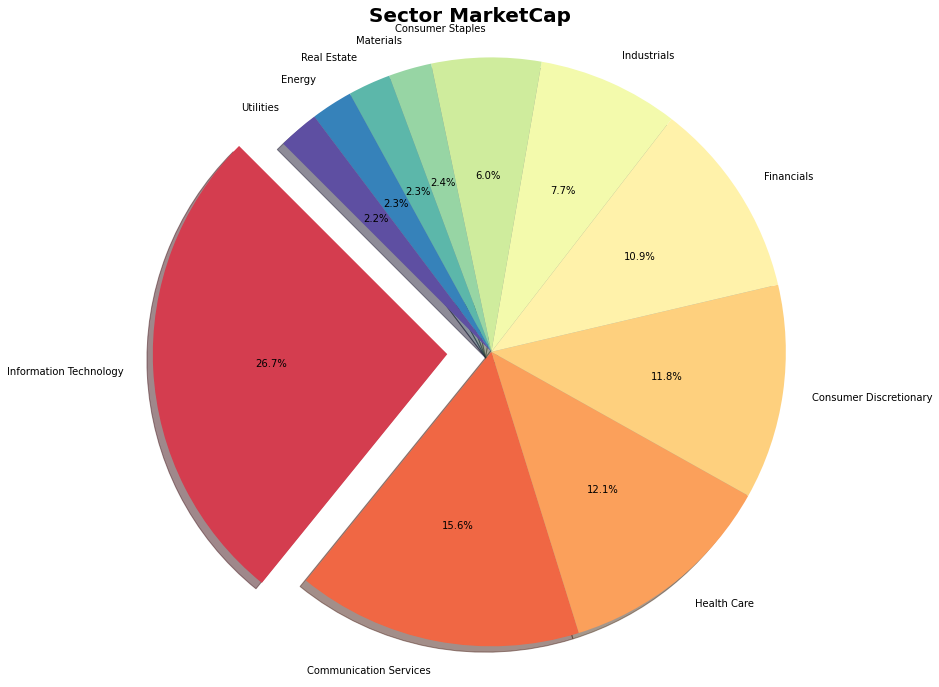

In [103]:
sector_marcap = sp500.groupby('Sector')['MarCap'].sum().sort_values(ascending=False)
values = sector_marcap.values
labels = sector_marcap.index
n = len(labels)

plt.figure(figsize=(15,12))
plt.title('Sector MarketCap', fontsize = 20, fontweight = 'bold')
plt.pie(values, labels=labels, colors=make_colors(n), explode=make_explode(n), autopct='%1.1f%%', shadow=True, startangle=135)
plt.axis('equal')
plt.show()

In [104]:
sp500.groupby('Sector').describe()['PER'].sort_values('mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Sector,,,,,,,,
Real Estate,25.00,112.51,259.23,11.44,31.36,51.29,72.90,1337.25
Information Technology,74.00,65.77,130.88,6.36,25.75,39.06,56.70,937.48
Consumer Discretionary,54.00,59.91,129.03,6.20,16.91,26.34,48.73,887.39
Energy,12.00,57.40,53.56,9.55,22.49,32.69,72.11,168.07
Health Care,58.00,40.58,26.28,5.80,21.62,34.95,51.22,120.46
Industrials,68.00,37.01,32.27,11.15,22.73,28.20,38.75,221.71
Communication Services,21.00,31.85,28.75,7.78,12.12,25.13,40.44,138.21
Materials,27.00,30.49,22.78,7.43,19.66,24.63,36.32,123.52
Consumer Staples,31.00,28.70,16.34,12.80,18.83,26.08,30.93,87.07


In [107]:
sp500.groupby('Sector').describe()['ROE'].sort_values('mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Sector,,,,,,,,
Consumer Staples,31.00,54.71,114.33,-74.80,12.50,26.50,40.60,514.40
Health Care,61.00,41.77,122.62,-369.90,12.40,19.40,34.70,764.10
Consumer Discretionary,61.00,40.72,165.39,-163.70,6.50,19.20,29.90,957.60
Materials,28.00,38.88,92.91,-5.80,12.88,17.45,26.77,504.10
Information Technology,72.00,37.05,77.71,-212.90,12.15,24.30,43.23,427.00
Communication Services,22.00,27.64,54.28,-7.90,6.58,17.85,27.40,263.90
Financials,64.00,18.68,45.51,-166.90,9.82,13.25,17.88,303.20
Industrials,71.00,18.08,58.18,-400.30,11.05,22.60,33.70,120.00
Real Estate,28.00,12.11,16.98,-9.40,3.20,6.75,12.92,58.00


In [200]:
sp500.groupby('Sector').describe()['PBR'].sort_values('mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Sector,,,,,,,,
Health Care,61.00,23.90,87.73,0.85,3.36,5.54,11.15,664.28
Consumer Discretionary,56.00,22.90,54.57,1.45,3.14,5.56,13.03,307.27
Consumer Staples,31.00,16.83,29.55,0.85,3.31,6.18,15.26,144.44
Information Technology,70.00,15.60,15.09,1.18,5.48,9.59,19.44,64.74
Materials,28.00,8.19,18.23,1.19,2.75,3.92,4.75,97.45
Industrials,69.00,6.92,4.58,1.63,3.10,5.73,8.97,20.90
Real Estate,28.00,5.13,4.73,1.60,2.26,3.12,6.05,22.16
Communication Services,25.00,4.22,3.46,1.12,1.64,3.14,5.13,16.49
Financials,64.00,4.21,11.19,0.00,1.15,1.48,3.10,84.14


In [131]:
# 1. PER/PBR, ROE rank 산출하기
PER_rank = sp500['PER'].rank(ascending = True, na_option = 'bottom')
PBR_rank = sp500['PBR'].rank(ascending = True, na_option = 'bottom')

In [132]:
ROE_rank = sp500['ROE'].rank(ascending = False, na_option = 'bottom')
DIV_rank = sp500['Dividend'].rank(ascending = False, na_option = 'bottom')

In [159]:
PERROE_rank = PER_rank + ROE_rank
PBRROE_rank = PBR_rank + ROE_rank

In [153]:
sp500.loc[np.where(PERROE_rank<=100)]

,Symbol,Name,Sector,Industry,MarCap,Dividend,PER,PBR,Beta,ROE
66,BIO,Bio-Rad Laboratories,Health Care,Life Sciences Tools & Services,22800000000.00,NaN,5.80,2.00,0.84,39.60
94,CE,Celanese,Materials,Specialty Chemicals,18090000000.00,1.68,7.43,4.80,1.23,75.40
125,COO,The Cooper Companies,Health Care,Health Care Supplies,21670000000.00,0.01,9.22,3.49,0.83,47.70
145,DFS,Discover Financial Services,Financials,Consumer Finance,40210000000.00,1.30,8.66,3.40,1.83,45.30
230,HOLX,Hologic,Health Care,Health Care Equipment,19470000000.00,NaN,9.87,5.08,1.17,59.70
290,LMT,Lockheed Martin,Industrials,Aerospace & Defense,99620000000.00,2.91,13.93,15.23,0.98,120.00
294,LYB,LyondellBasell,Materials,Specialty Chemicals,35120000000.00,4.30,8.59,3.35,1.53,47.30
345,NRG,NRG Energy,Utilities,Independent Power Producers & Energy Traders,10540000000.00,2.98,10.00,4.21,0.85,55.90
490,WU,Western Union,Information Technology,Data Processing & Outsourced Services,9120000000.00,4.18,11.49,32.13,1.02,427.00
493,WHR,Whirlpool Corporation,Consumer Discretionary,Household Appliances,14470000000.00,2.41,7.75,2.95,1.84,46.50


In [163]:
sp500.loc[np.where(PBRROE_rank<=250)]

,Symbol,Name,Sector,Industry,MarCap,Dividend,PER,PBR,Beta,ROE
66,BIO,Bio-Rad Laboratories,Health Care,Life Sciences Tools & Services,22800000000.00,NaN,5.80,2.00,0.84,39.60
77,BR,Broadridge Financial Solutions,Information Technology,Data Processing & Outsourced Services,658350000000.00,NaN,6.36,1.40,0.91,23.80
84,COF,Capital One Financial,Financials,Consumer Finance,78930000000.00,1.35,7.10,1.38,1.77,20.60
107,CINF,Cincinnati Financial,Financials,Property & Casualty Insurance,19640000000.00,2.08,6.90,1.65,0.68,26.20
162,EBAY,eBay,Consumer Discretionary,Internet & Direct Marketing Retail,46930000000.00,0.97,22.79,3.83,1.09,222.70
212,GM,General Motors,Consumer Discretionary,Automobile Manufacturers,79290000000.00,NaN,6.20,1.51,1.33,26.70
217,GS,Goldman Sachs,Financials,Investment Banking & Brokerage,139900000000.00,1.95,7.51,1.55,1.49,22.60
297,MPC,Marathon Petroleum,Energy,Oil & Gas Refining & Marketing,38000000000.00,3.92,NaN,1.33,2.16,32.20
473,VIAC,ViacomCBS,Communication Services,Movies & Entertainment,26030000000.00,2.45,7.78,1.26,1.68,19.40
493,WHR,Whirlpool Corporation,Consumer Discretionary,Household Appliances,14470000000.00,2.41,7.75,2.95,1.84,46.50


In [199]:
# 수익률 계산 PER + ROE

selected = sp500.loc[np.where(PERROE_rank<=100)]
start_date = '20210401'
end_date = '20210815'

for ind, val in enumerate(selected['Symbol'].values):
    symbol = selected.loc[selected['Symbol'] == val, 'Symbol'].values[0]
    df = fdr.DataReader(val, start_date, end_date)
    if ind == 0 :
        return_df = pd.DataFrame(index = df.index)
    df['rtn'] = df['Close'].pct_change(periods=1)
    df['cum_rtn'] = (1+df['rtn']).cumprod() - 1 
    tmp = df.loc[:,['cum_rtn']].rename(columns = {'cum_rtn':symbol})
    return_df = return_df.join(tmp, how = 'left')
    return_df.dropna()
    df = None
return_df    

,BIO,CE,COO,DFS,HOLX,LMT,LYB,NRG,WU,WHR
Date,,,,,,,,,,
2021-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-05,0.00,0.01,0.01,0.02,0.00,0.02,-0.01,0.00,-0.00,0.04
2021-04-06,0.01,0.01,0.01,0.02,0.01,0.02,-0.01,0.02,-0.00,0.04
2021-04-07,-0.01,-0.01,-0.01,0.02,-0.02,0.02,-0.02,0.02,0.00,0.02
2021-04-08,0.02,-0.01,-0.01,0.02,-0.01,0.04,-0.02,0.02,-0.00,0.04
...,...,...,...,...,...,...,...,...,...,...
2021-08-09,0.30,0.03,0.06,0.33,0.02,-0.03,-0.06,0.17,-0.10,-0.02
2021-08-10,0.32,0.06,0.05,0.36,0.03,-0.02,-0.02,0.15,-0.10,-0.01
2021-08-11,0.30,0.07,0.06,0.37,0.03,-0.02,0.00,0.15,-0.10,0.02


In [198]:
# 수익률 계산 PBR + ROE
selected = sp500.loc[np.where(PBRROE_rank<=250)]
start_date = '20210401'
end_date = '20210815'

for ind, val in enumerate(selected['Symbol'].values):
    symbol = selected.loc[selected['Symbol'] == val, 'Symbol'].values[0]
    df = fdr.DataReader(val, start_date, end_date)
    if ind == 0 :
        return_df = pd.DataFrame(index = df.index)
    df['rtn'] = df['Close'].pct_change(periods=1)
    df['cum_rtn'] = (1+df['rtn']).cumprod() - 1 
    tmp = df.loc[:,['cum_rtn']].rename(columns = {'cum_rtn':symbol})
    return_df = return_df.join(tmp, how = 'left')
    return_df.dropna()
    df = None
return_df   
    

,BIO,BR,COF,CINF,EBAY,GM,GS,MPC,VIAC,WHR
Date,,,,,,,,,,
2021-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-05,0.00,0.02,0.02,0.01,0.01,0.06,-0.01,-0.03,-0.04,0.04
2021-04-06,0.01,0.01,0.02,0.02,-0.01,0.07,-0.00,-0.04,-0.01,0.04
2021-04-07,-0.01,-0.00,0.02,0.01,-0.02,0.05,-0.00,-0.03,-0.02,0.02
2021-04-08,0.02,-0.00,0.02,0.00,-0.01,0.04,0.01,-0.04,-0.05,0.04
...,...,...,...,...,...,...,...,...,...,...
2021-08-09,0.30,0.12,0.28,0.15,0.04,-0.07,0.22,0.03,-0.10,-0.02
2021-08-10,0.32,0.11,0.32,0.16,0.07,-0.06,0.25,0.05,-0.09,-0.01
2021-08-11,0.30,0.11,0.34,0.16,0.08,-0.06,0.26,0.06,-0.09,0.02


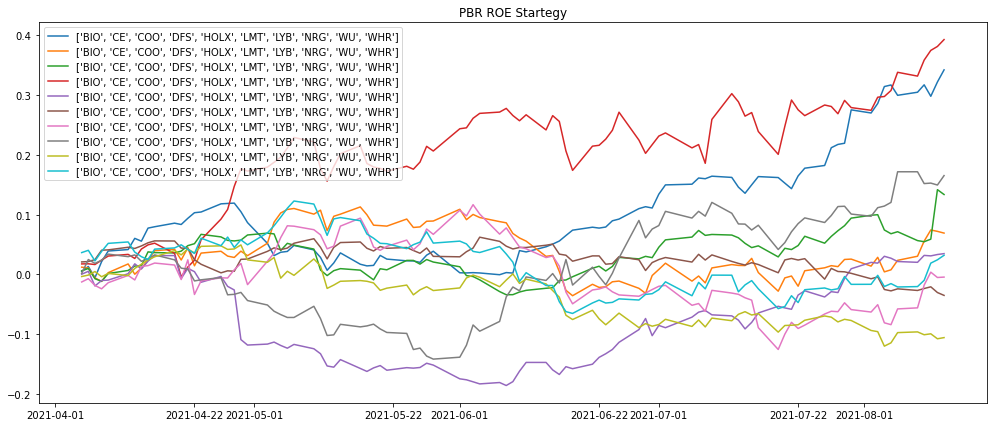

In [249]:
 # Cumulative Compounded Returns for valueStrategu
plt.figure(figsize=(17,7))
plt.title('PBR ROE Startegy')
plt.plot(return_df,label = [ i for i in ['BIO', 'CE', 'COO', 'DFS', 'HOLX', 'LMT', 'LYB', 'NRG', 'WU', 'WHR']]) 
# plt.plot(return_df,label = [ i for i in return_df.columns])
plt.legend()
plt.show()